In [39]:
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix

## Causal Weighted Graph Code

In [40]:
#subtract mean
def centre(Y):
    means = np.cumsum(Y,axis=1)
    Y_hat = Y - means
    return Y_hat

In [41]:
#fitting
def linreg(Y):
    As = {}
    m = Y.shape[0]
    t = Y.shape[1]
    print("m", m)
    print("t", t)
    for s in range(1,t+1):
        x0 = np.arange(1,s+1)

        x = np.row_stack((x0,x0))

        for i, j in itertools.combinations(range(m), 2):

            y = Y[(i,j),:s]

            reg = LinearRegression(fit_intercept=False).fit(x, y)
            As[(i,j,s)] = reg.coef_
    return As

In [57]:

#exponent
def calc_weights(Y,A,qs):
    weights = {}
    m = Y.shape[0]

    t = Y.shape[1]

    #for s in range(4,t+1):
    for q in qs:

        #x0 = np.arange(1,s+1)

        #x = np.row_stack((x0,x0))

        for i, j in itertools.combinations(range(m), 2):

            #y = Y[(i,j),:s]
            zsq = []
            #for q in qs:
            for s in range(4,t+1):
                y = Y[(i,j),:s]
                x0 = np.arange(1,s+1)

                x = np.row_stack((x0,x0))
                zs = 0
                for k in range(3,s):

                    z = y[:,:k].T - As[(i,j,k)] @ x[:,:k].T
                    if q != 0:
                        z = np.power(np.linalg.norm(z,ord=2),q)
                    else:
                        z = np.log(np.linalg.norm(z,ord=2))
                    zs += z
                if q != 0:
                    zs = np.float_power(zs,1/q)

                zsq.append(zs)
            if q != 0:

                weights[(i,j,q)] = np.polyfit(np.log(np.array(zsq)),np.log(range(4,t+1)),1)[0]
            else:
                weights[(i,j,q)] = np.polyfit(np.array(zsq),np.log(range(4,t+1)),1)[0]

    return weights

# Simulation of fake data

In [43]:
r0 = make_spd_matrix(n_dim=2,random_state=0)
r0

array([[ 2.54086605, -0.01128187],
       [-0.01128187,  0.52868286]])

In [44]:
num_samples = 64
mu = np.array([0, 0])
r = np.diag(np.diag(r0))
rng = np.random.default_rng(seed = 0)
y = rng.multivariate_normal(mu, r, size=num_samples,check_valid='warn')

In [45]:
Y = y.T
Yhat = centre(Y)
As = linreg(Yhat)
q = np.arange(-5,6)
weights = w(Yhat,As,q)

m 2
t 64


In [46]:

y0 = rng.multivariate_normal(mu, r0, size=num_samples,check_valid='warn')
Y = y0.T
Yhat = centre(Y)
As = linreg(Yhat)
q = np.arange(-5,6)
weights0 = w(Yhat,As,q)


m 2
t 64


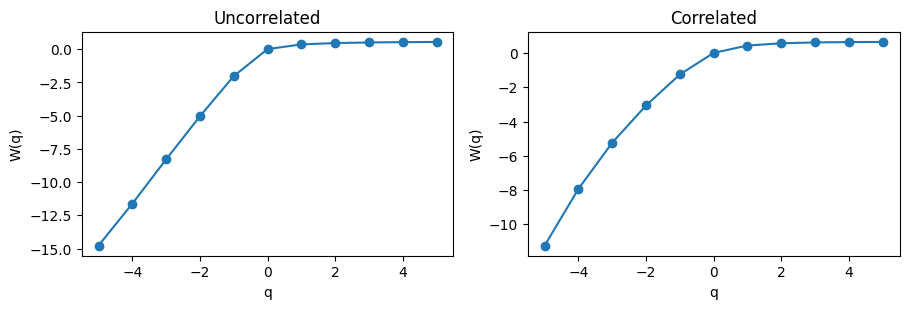

In [47]:
fig, axs = plt.subplots(1,2,figsize=(9,3))

axs[0].plot(q, weights.values(),'-o')
axs[1].plot(q, weights0.values(),'-o')
axs[0].set_title('Uncorrelated')
axs[1].set_title('Correlated')
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
for ax in axs.flat:
    ax.set(xlabel='q', ylabel='W(q)')
plt.show()

In [48]:
w = np.array(list(weights.values()))
tau = q*w - 1
f = q[:-1] * np.diff(tau) - tau[:-1]
#D = tau / (q-1)

In [49]:
tau

array([ 7.28649905e+01,  4.54720613e+01,  2.38536465e+01,  9.08143352e+00,
        1.02124116e+00, -1.00000000e+00, -6.35052960e-01, -6.71747402e-02,
        5.34488028e-01,  1.14205012e+00,  1.74660571e+00])

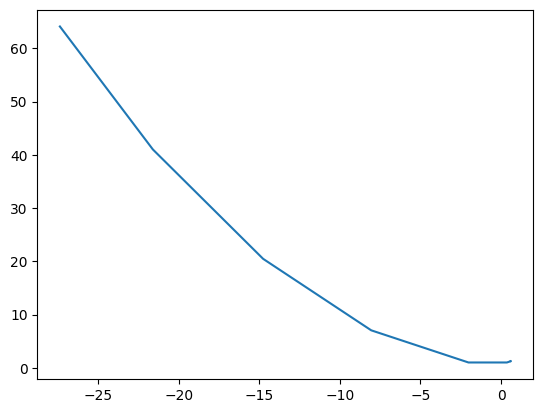

In [50]:
plt.plot(np.diff(tau),f)

In [51]:
w0 = np.array(list(weights0.values()))
tau0 = q*w0 - 1
f0 = q[:-1] * np.diff(tau0)/np.diff(q) - tau0[:-1]
D0 = tau0 / (q-1)

/var/folders/_t/wkz76zf10112hkp5k80v9w540000gp/T/ipykernel_21643/3808761943.py:4: RuntimeWarning: divide by zero encountered in divide
  D0 = tau0 / (q-1)


NameError: name 'D' is not defined

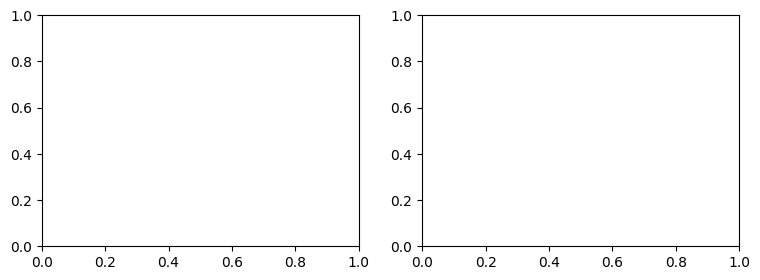

In [52]:
fig, axs = plt.subplots(1,2,figsize=(9,3))

axs[0].plot(q, D,'-o')
axs[1].plot(q, D0,'-o')
axs[0].set_title('Uncorrelated')
axs[1].set_title('Correlated')
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
for ax in axs.flat:
    ax.set(xlabel='q', ylabel='D(q)')
plt.show()

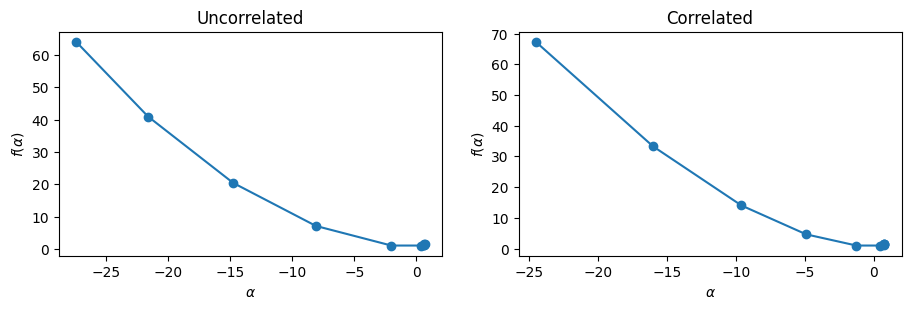

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(9,3))

axs[0].plot(np.diff(tau)/np.diff(q), f,'-o')
axs[1].plot(np.diff(tau0)/np.diff(q), f0,'-o')
axs[0].set_title('Uncorrelated')
axs[1].set_title('Correlated')
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
for ax in axs.flat:
    ax.set(xlabel=r'$\alpha$', ylabel=r'$f(\alpha)$')
plt.show()

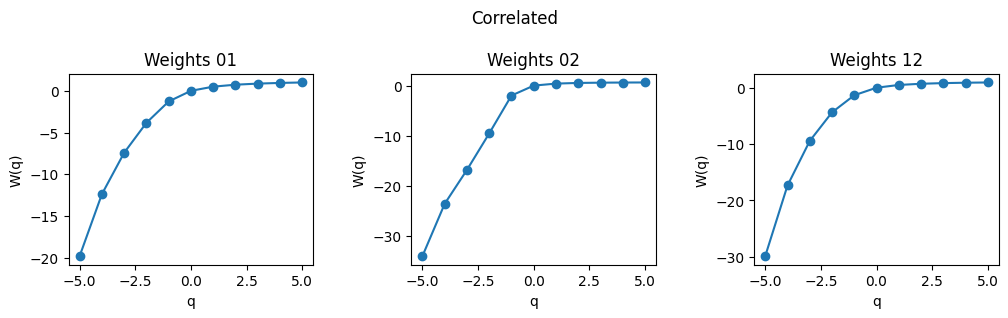

In [ ]:
h560 = []
h570 = []
h670 = []
for i in range(-5,6):
    h560.append(weights0[(0,1,i)])
    h570.append(weights0[(0,2,i)])
    h670.append(weights0[(1,2,i)])
fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Correlated')
axs[0].plot(q, np.array(h560),'-o')
axs[1].plot(q, np.array(h570),'-o')
axs[2].plot(q, np.array(h670),'-o')
axs[0].set_title('Weights 01')
axs[1].set_title('Weights 02')
axs[2].set_title('Weights 12')
fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
for ax in axs.flat:
    ax.set(xlabel='q', ylabel='W(q)')
plt.show()

In [ ]:
h56 = []
h57 = []
h67 = []
for i in range(-5,6):
    h56.append(weights0[(0,1,i)])
    h57.append(weights0[(0,2,i)])
    h67.append(weights0[(1,2,i)])

h56 = np.array(h56)
h57 = np.array(h57)
h67 = np.array(h67)
tau56 = q*h56 - 1
tau57 = q*h57 - 1
tau67 = q*h67 - 1
f56 = q[:-1] * np.diff(tau56)/np.diff(q) - tau56[:-1]
D56 = tau56 / (q-1)
f57 = q[:-1] * np.diff(tau57)/np.diff(q) - tau57[:-1]
D57 = tau57 / (q-1)
f67 = q[:-1] * np.diff(tau67)/np.diff(q) - tau67[:-1]
D67 = tau67 / (q-1)

<ipython-input-87-ec9bb6a226fe>:16: RuntimeWarning: divide by zero encountered in divide
  D56 = tau56 / (q-1)
<ipython-input-87-ec9bb6a226fe>:18: RuntimeWarning: divide by zero encountered in divide
  D57 = tau57 / (q-1)
<ipython-input-87-ec9bb6a226fe>:20: RuntimeWarning: divide by zero encountered in divide
  D67 = tau67 / (q-1)


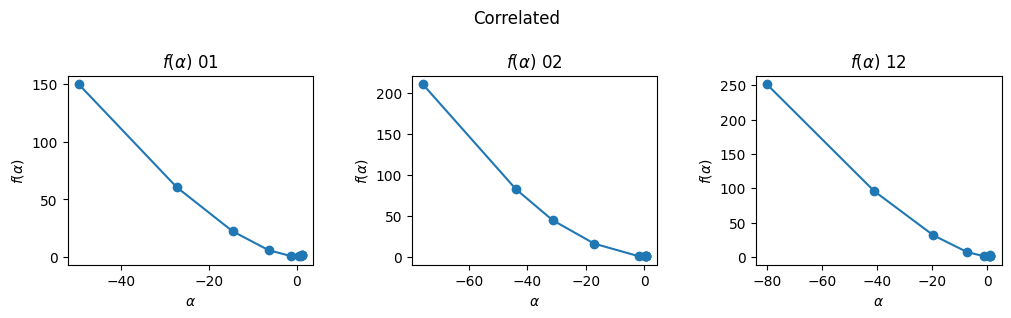

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(10,3))
fig.suptitle('Correlated')
axs[0].plot(np.diff(tau56)/np.diff(q), f56,'-o')
axs[1].plot(np.diff(tau57)/np.diff(q), f57,'-o')
axs[2].plot(np.diff(tau67)/np.diff(q), f67,'-o')
axs[0].set_title(r'$f(\alpha)$ 01')
axs[1].set_title(r'$f(\alpha)$ 02')
axs[2].set_title(r'$f(\alpha)$ 12')
fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
for ax in axs.flat:
    ax.set(xlabel=r'$\alpha$', ylabel=r'$f(\alpha)$')
plt.show()

# Another example
based on the "Time series Causal Discovery..."

In [66]:
import numpy as np

T = 10
X = np.ones((10, T))
eta = [np.random.normal(0, 1, T) for _ in range(10)]

for t in range(9, T):
    X[0, t] = 0.3 * X[0, t-4] + 0.4 * X[0, t-2] + eta[0][t]
    
    X[1, t] = (0.4 * X[1, t-4] + 0.5 * X[3, t-4] + 0.3 * (X[3, t-2]**2) + 
               0.4 * X[0, t-5] + 0.3 * (X[0, t-9]**2) + 0.3 * (X[4, t-1]**2) +
               0.4 * X[4, t-7] + 0.4 * X[6, t-3] + 0.6 * X[6, t-8] + eta[1][t])
    
    X[2, t] = 0.4 * X[4, t-1] + 0.2 * X[2, t-2] + eta[2][t]
    
    X[3, t] = 0.1 * X[3, t-3] + 0.3 * X[3, t-2] + 0.4 * X[2, t-6] + eta[3][t]
    
    X[4, t] = 0.3 * X[4, t-8] + 0.3 * X[4, t-1] + eta[4][t]
    
    X[5, t] = 0.5 * X[5, t-5] + 0.2 * X[5, t-9] + eta[5][t]
    
    X[6, t] = 0.4 * X[6, t-8] + 0.4 * X[6, t-9] + eta[6][t]
    
    X[7, t] = (0.5 * X[7, t-9] + 0.8 * X[4, t-1] + 0.7 * X[4, t-6] + 
               0.4 * X[5, t-7] + 0.6 * X[5, t-8] + 0.9 * X[8, t-1] +
               0.7 * (X[8, t-2]**2) + 0.7 * X[9, t-3] + 0.8 * X[9, t-4] + eta[7][t])
    
    X[8, t] = 0.1 * X[8, t-1] + 0.1 * X[8, t-2] + eta[8][t]
    
    X[9, t] = 0.3 * X[9, t-7] + 0.5 * X[9, t-8] + eta[9][t]



In [67]:
X

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.80208797],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  3.45206244],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.18208852],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        , -0.61668274],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.52555112],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  2.05043374],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        

In [68]:
X = X.T
Xhat = centre(X)
print("Xhat", Xhat)
As = linreg(Xhat)
print("As",As)
q = np.arange(-5,6)
weights = calc_weights(Xhat,As,q)

Xhat [[ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.      

/var/folders/_t/wkz76zf10112hkp5k80v9w540000gp/T/ipykernel_21643/3444420845.py:30: RuntimeWarning: divide by zero encountered in power
  z = np.power(np.linalg.norm(z,ord=2),q)
/var/folders/_t/wkz76zf10112hkp5k80v9w540000gp/T/ipykernel_21643/3444420845.py:40: RuntimeWarning: divide by zero encountered in log
  weights[(i,j,q)] = np.polyfit(np.log(np.array(zsq)),np.log(range(4,t+1)),1)[0]
/Users/athenasaghi/anaconda3/envs/CognitiveFatigue/lib/python3.11/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares